In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, average_precision_score
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


In [2]:
df=pd.read_csv(r"C:\Users\varad\Downloads\Fraud.csv")

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


#### <span style="color:blue">feature engineering df['step'] because of temporal variation</span>

step, is for hours in a month of 31 days. so, we can split that column into hour_of_day, day_of_week and week_of_month. Why? because when a plot was done on hourly transactions over time, there is temporal in scale of hours, day of the week and a week of the month. as shown below.

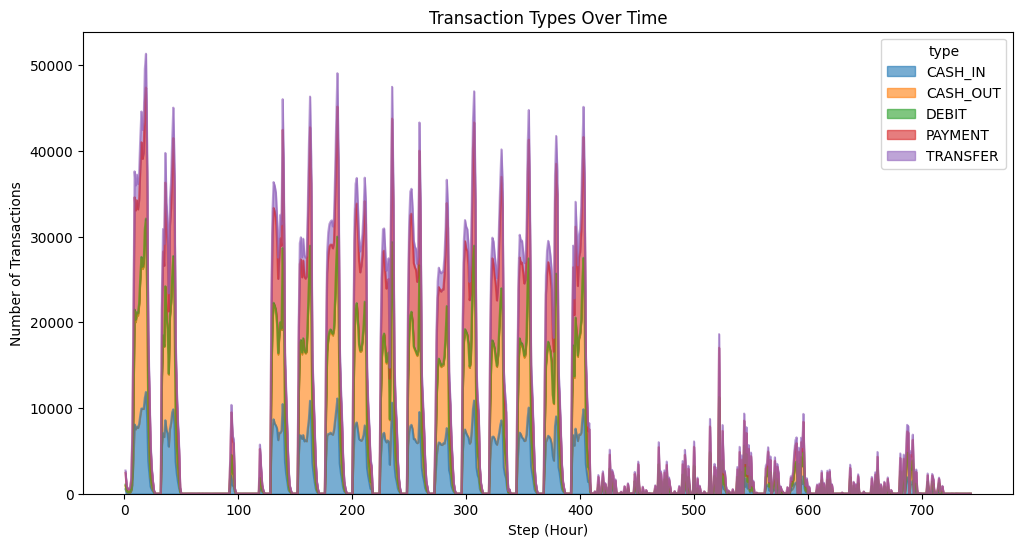

In [4]:
type_over_time = df.groupby(["step", "type"]).size().unstack(fill_value=0)
type_over_time.plot.area(figsize=(12,6),alpha=0.6)
plt.title("Transaction Types Over Time")
plt.xlabel("Step (Hour)")
plt.ylabel("Number of Transactions")
plt.show()

In [5]:
df['hour_of_day']= df['step']%24
df['day_of_week']=((df['step']//24)%7) + 1
df["week_of_month"] = (df["step"] // (24*7)) +1

In [6]:
df=df.drop(columns=['step'])

In [7]:
df.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour_of_day,day_of_week,week_of_month
0,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,1,1,1
1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1,1,1
2,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,1,1,1
3,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,1,1,1
4,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,1,1,1


#### <span style="color:blue">feature engineering df['type']</span>

the column 'type' will be onehot encoded, because the frauds are dependant on type of transaction. especially, TRANSFER and CASH_OUT are the only ones which are fraudulent events.

In [8]:
df=pd.get_dummies(df,columns=['type'])

In [9]:
df.head()

,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour_of_day,day_of_week,week_of_month,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,1,1,1,False,False,False,True,False
1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1,1,1,False,False,False,True,False
2,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,1,1,1,False,False,False,False,True
3,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,1,1,1,False,True,False,False,False
4,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,1,1,1,False,False,False,True,False


#### <span style="color:blue">feature engineering df['oldbalanceOrg'] and df['newbalanceOrig']</span> 

the correlation between 'amount' and the difference between 'oldbalanceOrg' and 'newbalanceOrig' is 1. so let's keep only 'amount'by dropping old and new balance of orig.

In [10]:
df = df.drop(columns=['oldbalanceOrg',	'newbalanceOrig'])

In [11]:
df

,amount,nameOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour_of_day,day_of_week,week_of_month,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9839.64,C1231006815,M1979787155,0.00,0.00,0,0,1,1,1,False,False,False,True,False
1,1864.28,C1666544295,M2044282225,0.00,0.00,0,0,1,1,1,False,False,False,True,False
2,181.00,C1305486145,C553264065,0.00,0.00,1,0,1,1,1,False,False,False,False,True
3,181.00,C840083671,C38997010,21182.00,0.00,1,0,1,1,1,False,True,False,False,False
4,11668.14,C2048537720,M1230701703,0.00,0.00,0,0,1,1,1,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,339682.13,C786484425,C776919290,0.00,339682.13,1,0,23,3,5,False,True,False,False,False
6362616,6311409.28,C1529008245,C1881841831,0.00,0.00,1,0,23,3,5,False,False,False,False,True
6362617,6311409.28,C1162922333,C1365125890,68488.84,6379898.11,1,0,23,3,5,False,True,False,False,False
6362618,850002.52,C1685995037,C2080388513,0.00,0.00,1,0,23,3,5,False,False,False,False,True


#### <span style="color:blue">feature engineering df['nameDest']</span> 

theres no new and old balance data on destination accounts. However, inspecting the data will tell us that if Dest begins with  'M' then no fraud. therefore, we can make nameDest as 0/1 to define merchant or a customer. when we sum in all fraud cases for merchant Destinations, the sum is 0. hence, we can safely say that merchants as destination, are not Frauds.

In [12]:
df[df['nameDest'].str.startswith('M')]['isFraud'].sum()

np.int64(0)

In [13]:
mask = (df['nameDest'].str[0]=='M')
df['merchant_destination']=mask

In [14]:
df=df.drop(columns=['nameDest'])

In [16]:
df.head()

,amount,nameOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour_of_day,day_of_week,week_of_month,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,merchant_destination
0,9839.64,C1231006815,0.0,0.0,0,0,1,1,1,False,False,False,True,False,True
1,1864.28,C1666544295,0.0,0.0,0,0,1,1,1,False,False,False,True,False,True
2,181.00,C1305486145,0.0,0.0,1,0,1,1,1,False,False,False,False,True,False
3,181.00,C840083671,21182.0,0.0,1,0,1,1,1,False,True,False,False,False,False
4,11668.14,C2048537720,0.0,0.0,0,0,1,1,1,False,False,False,True,False,True


#### <span style="color:blue">isFraud and isFlaggedFraud</span> 

Flagging a fraud is what current system does. we can test the efficacy of it by doing collinearilty and decide if we want to have both columns.

In [18]:
df[['isFraud','isFlaggedFraud']].corr()

,isFraud,isFlaggedFraud
isFraud,1.000000,0.044109
isFlaggedFraud,0.044109,1.000000


In [23]:
# lets see if flagging is efficient...this gives Fraud when flagged as Fraud
exp= df[(df['isFraud']==1) & (df['isFlaggedFraud']==1)]
len(exp)

16

In [25]:
# total Frauds
exp_new= df[(df['isFraud']==1)]
len(exp_new)

8213

In [27]:
#so FlaggingFraud methos is only this percent 
(len(exp)/len(exp_new))*100

0.1948131011810544

In [29]:
###Also another verification of rou_auc on assuming Flag as predictor and isFraud as truth values, we can calculate area under the curve.
roc_auc = roc_auc_score(df['isFraud'], df['isFlaggedFraud'])
roc_auc

np.float64(0.5009740655059053)

In [30]:
# as roc_auc is nealry 0.5, the Falgging policy currently employed is ineffective i.e random in prediction so ignore  'isFlaggedFraud'
df=df.drop(columns=['isFlaggedFraud'])

In [31]:
df.head()

,amount,nameOrig,oldbalanceDest,newbalanceDest,isFraud,hour_of_day,day_of_week,week_of_month,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,merchant_destination
0,9839.64,C1231006815,0.0,0.0,0,1,1,1,False,False,False,True,False,True
1,1864.28,C1666544295,0.0,0.0,0,1,1,1,False,False,False,True,False,True
2,181.00,C1305486145,0.0,0.0,1,1,1,1,False,False,False,False,True,False
3,181.00,C840083671,21182.0,0.0,1,1,1,1,False,True,False,False,False,False
4,11668.14,C2048537720,0.0,0.0,0,1,1,1,False,False,False,True,False,True


#### <span style="color:blue">Dealing with nameOrig</span> 

This cannot b a feature in itself, becasue it will have high sparse vectors of zeros and few 1s. so one possible thing to do here, is to check if the nameOrig has done multiple transactions. At max an account has made a maximum of three transactions. 

In [36]:
df['transaction_by_an_account']=df.groupby("nameOrig")["amount"].transform("count")

In [55]:
len(df[df['transaction_by_an_account']==1]),len(df[df['transaction_by_an_account']==2]),len(df[df['transaction_by_an_account']==3]),len(df[df['transaction_by_an_account']==4])

(6344009, 18566, 45, 0)

In [ ]:
df=df.drop(columns=['nameOrig'])

In [61]:
df.head()

,amount,oldbalanceDest,newbalanceDest,isFraud,hour_of_day,day_of_week,week_of_month,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,merchant_destination,transaction_by_an_account
0,9839.64,0.0,0.0,0,1,1,1,False,False,False,True,False,True,1
1,1864.28,0.0,0.0,0,1,1,1,False,False,False,True,False,True,1
2,181.00,0.0,0.0,1,1,1,1,False,False,False,False,True,False,1
3,181.00,21182.0,0.0,1,1,1,1,False,True,False,False,False,False,1
4,11668.14,0.0,0.0,0,1,1,1,False,False,False,True,False,True,1


#### <span style="color:blue">consistency_balance at destination accounts</span> 

we will craete a new column named cosnistency_balance, that will test if the difference between old and new balance of destination is consistent with amounts column. 

In [64]:
df['consistency_balance'] = (df['newbalanceDest']-df['oldbalanceDest']-df['amount']==0)

In [65]:
df

,amount,oldbalanceDest,newbalanceDest,isFraud,hour_of_day,day_of_week,week_of_month,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,merchant_destination,transaction_by_an_account,consistency_balance
0,9839.64,0.00,0.00,0,1,1,1,False,False,False,True,False,True,1,False
1,1864.28,0.00,0.00,0,1,1,1,False,False,False,True,False,True,1,False
2,181.00,0.00,0.00,1,1,1,1,False,False,False,False,True,False,1,False
3,181.00,21182.00,0.00,1,1,1,1,False,True,False,False,False,False,1,False
4,11668.14,0.00,0.00,0,1,1,1,False,False,False,True,False,True,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,339682.13,0.00,339682.13,1,23,3,5,False,True,False,False,False,False,1,True
6362616,6311409.28,0.00,0.00,1,23,3,5,False,False,False,False,True,False,1,False
6362617,6311409.28,68488.84,6379898.11,1,23,3,5,False,True,False,False,False,False,1,False
6362618,850002.52,0.00,0.00,1,23,3,5,False,False,False,False,True,False,1,False


In [66]:
df= df.drop(columns=['oldbalanceDest','newbalanceDest'])

In [67]:
df.head()

,amount,isFraud,hour_of_day,day_of_week,week_of_month,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,merchant_destination,transaction_by_an_account,consistency_balance
0,9839.64,0,1,1,1,False,False,False,True,False,True,1,False
1,1864.28,0,1,1,1,False,False,False,True,False,True,1,False
2,181.00,1,1,1,1,False,False,False,False,True,False,1,False
3,181.00,1,1,1,1,False,True,False,False,False,False,1,False
4,11668.14,0,1,1,1,False,False,False,True,False,True,1,False


#### <span style="color:blue">Model design for classification</span>  

We will use Decision trees here. The data as we know is highly skewed. There are 8212 fraudulent transactions amongst 63 Lakh transactions. We need to make sure that the class ratio emians same when divided into train and validate. SO we will use stratified split

In [74]:
total_trans= len(df)
total_trans

6362620

In [75]:
total_fraud = len(df[df['isFraud']==1])
total_fraud

8213

In [78]:
class_ratio= total_fraud/total_trans
class_ratio

0.001290820448180152

In [81]:
X=df[['amount',	'hour_of_day',	'day_of_week'	,'week_of_month'	,'type_CASH_IN',	'type_CASH_OUT'	,'type_DEBIT'	,'type_PAYMENT'	,'type_TRANSFER',	'merchant_destination'	,'transaction_by_an_account',	'consistency_balance']]

In [82]:
Y= df[['isFraud']]

In [83]:
X.head()

,amount,hour_of_day,day_of_week,week_of_month,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,merchant_destination,transaction_by_an_account,consistency_balance
0,9839.64,1,1,1,False,False,False,True,False,True,1,False
1,1864.28,1,1,1,False,False,False,True,False,True,1,False
2,181.00,1,1,1,False,False,False,False,True,False,1,False
3,181.00,1,1,1,False,True,False,False,False,False,1,False
4,11668.14,1,1,1,False,False,False,True,False,True,1,False


In [84]:
Y.head()

,isFraud
0,0
1,0
2,1
3,1
4,0


In [85]:
#stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, stratify=Y, random_state=2025
)

In [90]:
y_train.sum(), y_test.sum()         #frauds are distributed in 80:20 ratio

(isFraud    6570
 dtype: int64,
 isFraud    1643
 dtype: int64)

#### <span style="color:blue">XGBoost</span> 

With varying n_estimator, maximum_depth and learning_rate, the model still not up to the performance. The estimators will increase too much and the depth of the tree grows too much for this dataset.

In [116]:
# the true values being very less in proportion, we need to give different weights to Fraud and non-Fraud transxs. 
#because a random split can put all fraud transactions one side of split. so we will be using scale_pos_weight
model1 = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight = int((len(y_train)-y_train.sum()) / (y_train.sum())),  # handling imbalance
    random_state=2025,
    tree_method="hist" 
)

C:\Users\varad\AppData\Local\Temp\ipykernel_37252\878147852.py:9: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  scale_pos_weight = int((len(y_train)-y_train.sum()) / (y_train.sum())),  # handling imbalance


In [117]:
model1.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ...)

In [123]:
y_pred = model1.predict(X_test)

acc = accuracy_score(y_test, y_pred)

prec = precision_score(y_test, y_pred)

rec = recall_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred)
print(sum(y_pred))
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

56650
Accuracy:  0.9564
Precision: 0.0252
Recall:    0.8691
F1 Score:  0.0490


In [124]:
model2 = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=20,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight = int((len(y_train)-y_train.sum()) / (y_train.sum())),  # handling imbalance
    random_state=2025,
    tree_method="hist"  
)

C:\Users\varad\AppData\Local\Temp\ipykernel_37252\4176349659.py:7: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  scale_pos_weight = int((len(y_train)-y_train.sum()) / (y_train.sum())),  # handling imbalance


In [125]:
model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)

acc = accuracy_score(y_test, y_pred)

prec = precision_score(y_test, y_pred)

rec = recall_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred)
print(sum(y_pred))
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

9220
Accuracy:  0.9928
Precision: 0.0925
Recall:    0.5192
F1 Score:  0.1570


#### <span style="color:blue">RandomForest</span> 

trying the ensemble method of decision tree classifier. max_depth is kept None, to progress until the last leaf nodes are pure in that, no more child nodes.  Amount column is not normalized as normalization does usually affect in Decision trees.

In [132]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(class_weight="balanced", n_estimators=300, max_depth=None, random_state=2025)
model_rf.fit(X_train, y_train)

C:\Users\varad\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(class_weight='balanced', n_estimators=300,
                       random_state=2025)

In [133]:
y_pred = model_rf.predict(X_test)

acc = accuracy_score(y_test, y_pred)

prec = precision_score(y_test, y_pred)

rec = recall_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred)
print(sum(y_pred))
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

984
Accuracy:  0.9991
Precision: 0.7683
Recall:    0.4601
F1 Score:  0.5756


In [ ]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(class_weight="balanced", n_estimators=600, max_depth=None, random_state=2025)
model_rf.fit(X_train, y_train)

In [ ]:
y_pred = model_rf.predict(X_test)

acc = accuracy_score(y_test, y_pred)

prec = precision_score(y_test, y_pred)

rec = recall_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred)
print(sum(y_pred))
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

#### <span style="color:blue">Logit Regression</span> 

Very much out of range in prediction for this case as seen below. That is probably because, the classes are not separable by a hyperplane.The data might need non-linear separatyion. The SCOPE to improve is that, we need to normalize the amount and destination account columns, because, the logit model is sensitive to the non standard scaled data feature.

In [131]:
from sklearn.linear_model import LogisticRegression
model_log = LogisticRegression(class_weight="balanced", max_iter=1000)
model_log.fit(X_train, y_train)
y_pred = model_log.predict(X_test)

acc = accuracy_score(y_test, y_pred)

prec = precision_score(y_test, y_pred)

rec = recall_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred)
print(sum(y_pred))
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

C:\Users\varad\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


229727
Accuracy:  0.8204
Precision: 0.0062
Recall:    0.8698
F1 Score:  0.0124


The recall is very important in detecting fraud because we would rather have false positives than fasle negatives.
The recall is higher for logit regression. However, normalization is important. 
So normalization of amount column is done and logit is executed again.
We will do Log Transformation becasue such normalization works, when the data is too skewed as in this case, because, the amount of transactions
are also very widely varying.

In [140]:
# normalizing X['amount']

import numpy as np
X["amount_normalized"] = np.log1p(X["amount"])

In [142]:
X = X.drop(columns=['amount'])

In [143]:
X.head()

,hour_of_day,day_of_week,week_of_month,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,merchant_destination,transaction_by_an_account,consistency_balance,amount_normalized
0,1,1,1,False,False,False,True,False,True,1,False,9.194276
1,1,1,1,False,False,False,True,False,True,1,False,7.531166
2,1,1,1,False,False,False,False,True,False,1,False,5.204007
3,1,1,1,False,True,False,False,False,False,1,False,5.204007
4,1,1,1,False,False,False,True,False,True,1,False,9.364703


In [144]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, stratify=Y, random_state=2025
)

In [146]:
model_log = LogisticRegression(class_weight="balanced", max_iter=3000)
model_log.fit(X_train, y_train)
y_pred = model_log.predict(X_test)

acc = accuracy_score(y_test, y_pred)

prec = precision_score(y_test, y_pred)

rec = recall_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred)
print(sum(y_pred))
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

C:\Users\varad\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


269795
Accuracy:  0.7890
Precision: 0.0053
Recall:    0.8752
F1 Score:  0.0106


#### <span style="color:blue">How did you select variables to be included in the model?</span>  

The rationale of choosing the features and engineering are explained while execution of readying the dataframe.

#### <span style="color:blue">What are the key factors that predict fraudulent customer?</span>  

TYPE OF TRANSFER : On the face of it, its clear that when type of trasactions are TRANSFER and CASH_OUT the frauds are exclusive. 
TYPE OF DESTINATION ACCOUNT: If its Merchant, the model would predict non fraudulent, as there's no scope for any probability to exist based on data.

Others seem to make less impact. In this view, a simple model with Type of Transfer and Type of destination account can be made. And that try is as below.

#### <span style="color:blue">What kind of prevention should be adopted while company update its infrastructure?</span>

Given that predictions take time, with choosing a model and concentrating highly on minimizing the false negatives, we need to make sure og high computation power and more servers for consistent response for requests.

Backups & snapshots → Ensure data is backed up and recovery is tested before updates.
Use load balancers, clusters, or replicas to keep services running.
Log all changes and track health metrics in real time.

#### <span style="color:blue">Assuming these actions have been implemented, how would you determine if they work?</span>

proven by monitoring, security scans, and audit/metrics review.